In [1]:
import numpy as np
import random
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [3]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [4]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [5]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

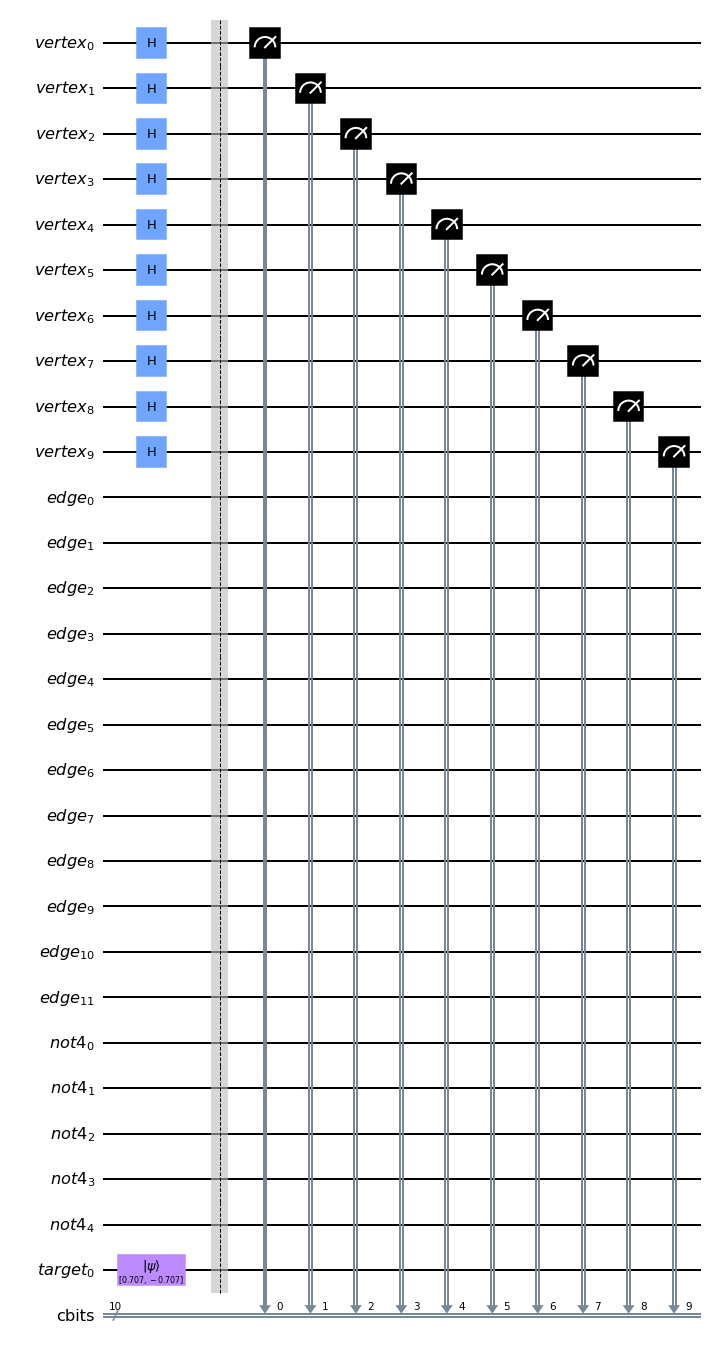

In [6]:
#example (v為vertex, e為edge)
# ex 1 
v_list = [0,1,2,3,4]
e_list = [[0,1],[1,2],[1,3], [1,4]]

# ex 2
#v_list = [0,1,2,3,4,5,6,7,8,9]
#e_list = [[0,1],[0,4],[0,5],[1,2],[1,6],[2,3],[2,7],[3,4],[3,8],[4,9],[5,7],[5,8],[6,8],[6,9],[7,9]]

#ex 3
#v_list = [0,1,2]
#e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 9

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取4
xx = random.randint(0,7)
for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

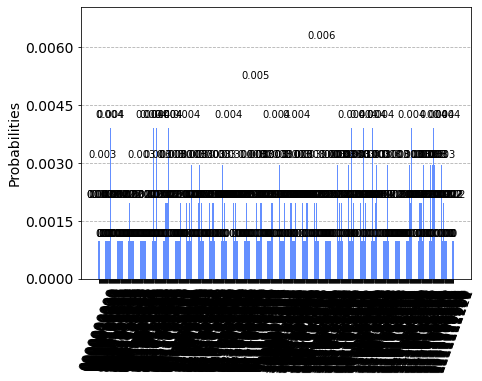

In [7]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

[['1001111110', 6], ['0111010011', 5], ['1110001000', 4], ['1000001101', 4], ['0011001111', 4], ['0010100001', 4], ['0000100010', 4], ['1100101111', 4], ['0110000010', 4], ['0100000111', 4], ['1111010101', 4], ['1111101010', 4], ['0010010111', 4], ['0011010000', 4], ['1100011010', 4], ['1011010110', 4], ['0010101100', 4], ['0000100101', 4], ['1000111101', 4], ['1110111110', 4], ['1011111111', 4], ['1011000000', 3], ['0100011001', 3], ['0111111111', 3], ['1001011000', 3], ['1110000000', 3], ['1110110100', 3], ['1101100001', 3], ['0111010001', 3], ['1010111011', 3], ['0000010000', 3], ['0111100000', 3], ['0011100000', 3], ['0011100001', 3], ['0100011101', 3], ['0101111100', 3], ['0010000100', 3], ['1111010111', 3], ['1110111100', 3], ['1001000110', 3], ['1001000101', 3], ['1001100010', 3], ['1000111111', 3], ['1010110000', 3], ['1010101111', 3], ['0111001100', 3], ['1100100011', 3], ['1010100010', 3], ['1101000010', 3], ['0101100010', 3], ['1000001111', 3], ['1011111010', 3], ['110001101

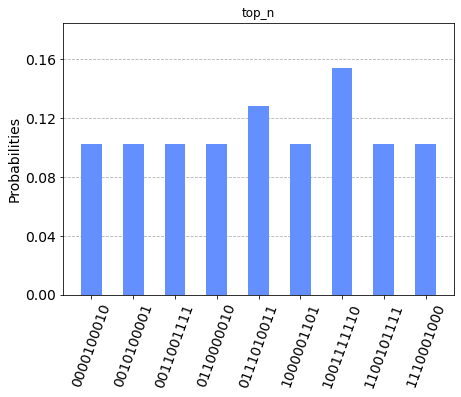

In [8]:
p1 = []
p2 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [9]:
print(counts)

{'0000000100': 1, '1000010001': 1, '1011011001': 1, '1111101101': 1, '0100000100': 1, '1111000111': 1, '0110010100': 1, '1001101111': 1, '1110001101': 1, '0111110100': 1, '0100111111': 1, '1101100110': 1, '1111001111': 1, '0011000101': 1, '0101011000': 2, '0101010000': 1, '0111010010': 1, '1110010111': 1, '1101000110': 1, '1100011000': 1, '1100010100': 1, '0011100110': 1, '1101111101': 1, '0010101001': 1, '1010100111': 1, '1001100001': 1, '0111111001': 1, '0000110011': 1, '1000010000': 2, '1000100001': 2, '0011011011': 1, '0111000100': 1, '1010100000': 1, '0011101001': 1, '0100111101': 1, '1110001001': 2, '0010001101': 1, '1100111101': 1, '1000101011': 1, '0101010001': 1, '1000110000': 1, '0101001000': 1, '0101000011': 1, '1000101010': 1, '1011010111': 1, '0110011111': 1, '1001001101': 2, '1101000011': 2, '0100001101': 1, '0010001011': 1, '0101000101': 1, '1110100010': 1, '0111110010': 1, '0000001010': 1, '0100001010': 1, '1000011111': 2, '0010000011': 1, '1100001011': 2, '0001101110':

In [10]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'1011001001': 1, '0001100001': 1, '1100011000': 1, '0000101100': 1, '0001111101': 1, '1010011010': 1, '0011100001': 1, '1101100111': 1, '1010111011': 1, '1111001001': 1, '1001011111': 1, '1110101001': 1, '1010000001': 1, '1110111111': 1, '1111010010': 1, '1101011110': 1, '1110001001': 1, '0111011001': 1, '0101101110': 2, '1000011011': 1, '1011101101': 1, '1001011110': 1, '1010100111': 1, '1011011001': 1, '1111111000': 1, '1011110110': 1, '0001001000': 2, '0011000000': 1, '0100111101': 1, '0010101110': 2, '1110110101': 1, '0010100111': 1, '1000111000': 1, '0110101110': 1, '1000100011': 1, '1100110000': 1, '0111100101': 1, '1001001000': 1, '0101101111': 1, '0111101110': 1, '0111011111': 1, '0011001111': 1, '0001011000': 1, '0111011000': 1, '1011001011': 1, '1010100001': 1, '1100001010': 1, '1101100101': 1, '1110011100': 1, '0000111011': 2, '1001111100': 1, '1001111011': 1, '1001101011': 1, '0111010111': 1, '1101100001': 2, '0011010000': 1, '1000001001': 1, '1100011110': 1, '0001100010':

[['1110001011', 5], ['1100101100', 5], ['0001000110', 4], ['0000001001', 4], ['1110101010', 4], ['0010010010', 4], ['1100101110', 4], ['0010110110', 4], ['0000110001', 4], ['0111111110', 4], ['1001011101', 4], ['0011100011', 4], ['0000110100', 4], ['0101010110', 4], ['1000010101', 4], ['1001000011', 4], ['1000101111', 4], ['0010001000', 4], ['1101011111', 3], ['1010100011', 3], ['1100100000', 3], ['0001111000', 3], ['1011011110', 3], ['1011111011', 3], ['0001011111', 3], ['1010001000', 3], ['0100110000', 3], ['0100110011', 3], ['1001001101', 3], ['0000001011', 3], ['1100010000', 3], ['1111011101', 3], ['1011100101', 3], ['1110100100', 3], ['0110001001', 3], ['0001101100', 3], ['0001010010', 3], ['0010100110', 3], ['1010101101', 3], ['1111011001', 3], ['0101010101', 3], ['0100001010', 3], ['1010100000', 3], ['0011100010', 3], ['0001011001', 3], ['0110010010', 3], ['0010111001', 3], ['0010000000', 3], ['0011011100', 3], ['1101111001', 3], ['0110001000', 3], ['1100010001', 3], ['101010111

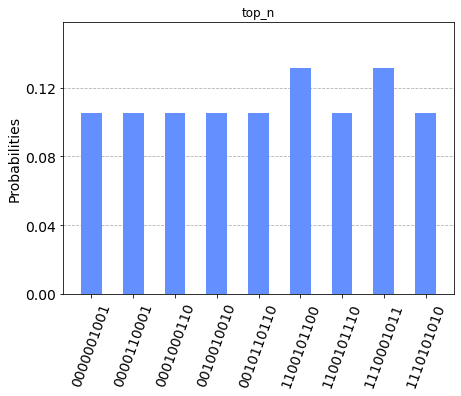

In [11]:
p3 = []
p4 = []
pause2 = results.get_counts()
pause2.clear()
di2 = dict.fromkeys(noisy_counts)
for i in di2.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
for i in range(top_n):
        b = p3[i]
        pause2.setdefault(b[0],b[1])
plot_histogram(pause2, title="top_n",bar_labels = False)

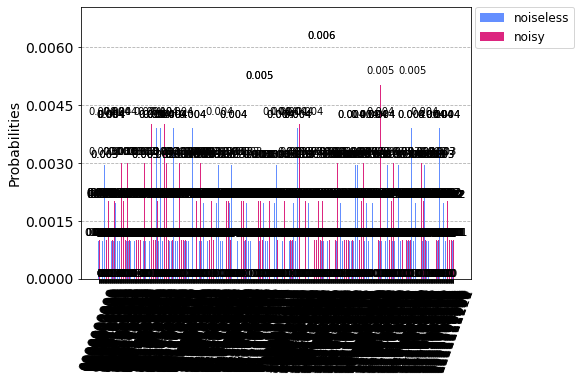

In [12]:
plot_histogram([counts, noisy_counts], legend=['noiseless', 'noisy'])

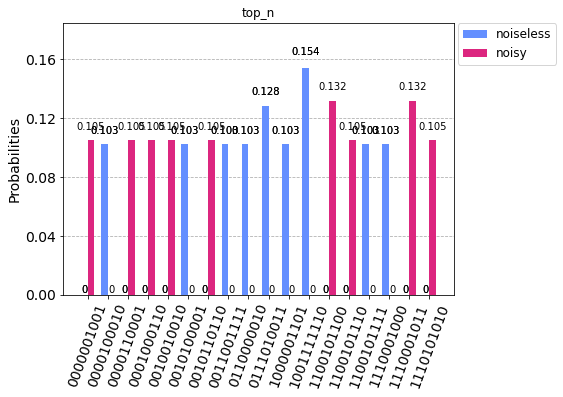

In [13]:
plot_histogram([pause, pause2], title="top_n", legend=['noiseless', 'noisy'])